
Demos - Geo - Spatial projections
=================================



# References

## DataBricks notebooks
* [Notebook - Demos - Geo - Spatial projections (this notebook)](https://github.com/data-engineering-helpers/databricks-examples/blob/main/ipython-notebooks/demos-geo-spatial-projections.ipynb)
* [Notebook - Demos - Geo - Show Simultaneous Changes in Geospatial Data - Part 1](https://github.com/data-engineering-helpers/databricks-examples/blob/main/ipython-notebooks/demos-geo-show-simultaneous-changes-in-geospatial-data-1_2.ipynb)
* [Notebook - Demos - Geo - Python Contextily package](https://github.com/data-engineering-helpers/databricks-examples/blob/main/ipython-notebooks/demos-geo-python-contextily-package.ipynb)

## Projections
### Geospatial projections
* Cylindrical Equal Area (CEA)(projection preserving areas): https://proj.org/operations/projections/cea.html
* Very detailed answer on GIS Stack Exchange/Stack Overflow: https://gis.stackexchange.com/a/401815/23550


In [0]:
%pip install geopandas cartopy

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.



# Choosing a projection
Note that the choice of a projection is very important for large shapes, especially near the poles.
As an example, we'll grab Greenland from Natural Earth:

In [0]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import shapely

f = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries_lakes', '50m')
countries = list(f.geometries())
# filter with an arbitrary point in greenland
greenland, = [
    c for c in countries
    if c.contains(shapely.geometry.Point(-41.4408857, 68.7165341))
]

gdf = gpd.GeoDataFrame({'geometry': [greenland]}, crs='epsg:4326')


/local_disk0/.ephemeral_nfs/envs/pythonEnv-57be99ea-4b11-46fa-a4f8-191f4f584336/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)



Depending on the projection chosen, you can get a wide range of centroids:

In [0]:
default_centroid = gdf.centroid
default_centroid

/root/.ipykernel/6408/command-4417673118080965-3860788208:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  default_centroid = gdf.centroid


0    POINT (-41.34191 74.71051)
dtype: geometry

In [0]:
centroid_mercator = gdf.to_crs('epsg:3785').centroid.to_crs(gdf.crs)
centroid_mercator

0    POINT (-41.08900 77.31320)
dtype: geometry

In [0]:
centroid_equal_area = gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)
centroid_equal_area

0    POINT (-41.55424 71.98766)
dtype: geometry


These three points are hundreds of km away from one another! So what's going on here?

The issue is that the different projections distort distances near the poles in different ways. The default centroid relies on math based on simple cartesian coordinates. This is equivalent to projecting the shape onto a simple Cylindrical (PlateCarree) projection - you get the same answer as the default if you use a cylindrical projection (e.g. "epsg:4087"). This inflates distances between longitudes, causing the centroid to be too-heavily influenced by the expanded northern parts of the shape. The mercator projection is even worse, and dramatically over-emphasizes higher-latitude areas. To correct this, use an area-preserving projection, such as
[Equal Area Cylindrical (`+proj=cea`)](https://proj.org/operations/projections/cea.html).



# Visualizing projection effects
## PlateCarree (WGS84, or simple lat/lon cartesian projection)
This is the default projection, and is equivalent to using a simple Cylindrical projection.
The red centroid dot appears in the center of the shape, because northern latitudes have been inflated.


/local_disk0/.ephemeral_nfs/envs/pythonEnv-57be99ea-4b11-46fa-a4f8-191f4f584336/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


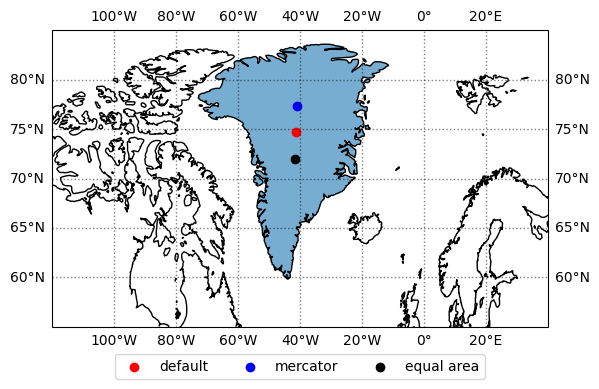

In [0]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
gdf.plot(ax=ax, alpha=0.6, transform=ccrs.PlateCarree())
ax.set_extent((-120, 40, 55, 85), crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='dotted')

l1 = ax.scatter(default_centroid.x, default_centroid.y, color='red', transform=ccrs.PlateCarree())
l2 = ax.scatter(centroid_mercator.x, centroid_mercator.y, color='blue', transform=ccrs.PlateCarree())
l3 = ax.scatter(centroid_equal_area.x, centroid_equal_area.y, color='k', transform=ccrs.PlateCarree())

ax.legend([l1, l2, l3], ['default', 'mercator', 'equal area'], bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=3)


## Equal area cylindrical projection
We can view the placement of the equal-area-based centroid by projecting the shape on a globe using the Orthographic projection. This allows us to see that using an equal area projection offers the truest centroid.


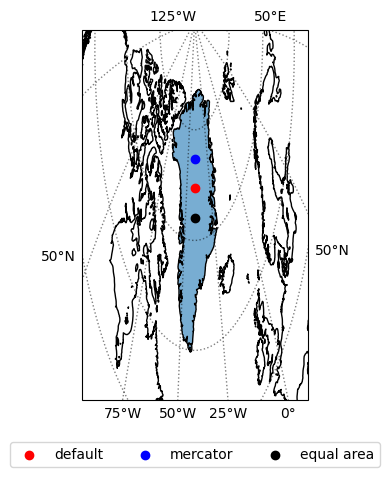

In [0]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Orthographic(centroid_equal_area.x[0], centroid_equal_area.y[0])})
gdf.plot(ax=ax, alpha=0.6, transform=ccrs.PlateCarree())
ax.set_extent((-120, 40, 55, 85), crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='dotted')

l1 = ax.scatter(default_centroid.x, default_centroid.y, color='red', transform=ccrs.PlateCarree())
l2 = ax.scatter(centroid_mercator.x, centroid_mercator.y, color='blue', transform=ccrs.PlateCarree())
l3 = ax.scatter(centroid_equal_area.x, centroid_equal_area.y, color='k', transform=ccrs.PlateCarree())

ax.legend([l1, l2, l3], ['default', 'mercator', 'equal area'], bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=3)


## Mercator
The mercator projection amplifies the distortion near the poles, giving a dramatic bias toward northern latitudes:



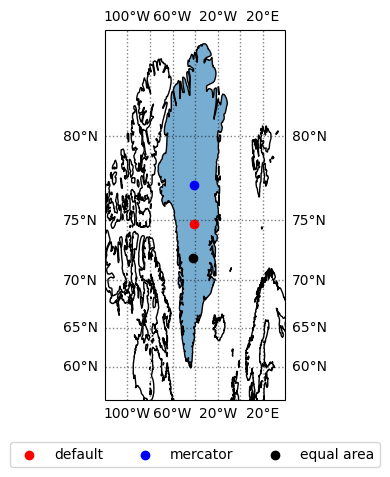

In [0]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Mercator()})
gdf.plot(ax=ax, alpha=0.6, transform=ccrs.PlateCarree())
ax.set_extent((-120, 40, 55, 85), crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='dotted')

l1 = ax.scatter(default_centroid.x, default_centroid.y, color='red', transform=ccrs.PlateCarree())
l2 = ax.scatter(centroid_mercator.x, centroid_mercator.y, color='blue', transform=ccrs.PlateCarree())
l3 = ax.scatter(centroid_equal_area.x, centroid_equal_area.y, color='k', transform=ccrs.PlateCarree())

ax.legend([l1, l2, l3], ['default', 'mercator', 'equal area'], bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=3)


Note that most web maps use a version of the Mercator projection. Therefore, if the goal is to have a visual centroid, Mercator may be the correct choice.